In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# data loading
from sklearn.preprocessing import LabelEncoder
import os
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_dataset(base_dir):
    features = []
    labels = []
    for genre in os.listdir(base_dir):
        genre_dir = os.path.join(base_dir, genre)
        if not os.path.isdir(genre_dir):
            continue
        for fname in os.listdir(genre_dir):
            if fname.endswith('.pt'):
                path = os.path.join(genre_dir, fname)
                tensor = torch.load(path).flatten().numpy()
                features.append(tensor)
                labels.append(genre)
    return np.array(features), np.array(labels)

file_dir = "/content/drive/MyDrive/split_data_small/"

X_train, y_train = load_dataset(file_dir + "train")
X_val, y_val = load_dataset(file_dir + "val")
X_test, y_test = load_dataset(file_dir + "test")

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

Mounted at /content/drive


In [3]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler

def get_data_loader(
    target_classes,
    batch_size=64,
    root_dir="/content/drive/MyDrive/split_data_small/",
    random_seed=1000
):
    """
    Adapted for music genre classification using pre-processed .pt files

    Args:
        target_classes: List of genre classes to include (or None for all)
        batch_size: samples per batch
        root_dir: path to directory containing train/val/test folders
        random_seed: for reproducible results

    Returns:
        train_loader, val_loader, test_loader, classes
    """

    # Set random seed for reproducibility
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

    # Load all datasets using existing function
    X_train, y_train = load_dataset(root_dir + "train")
    X_val, y_val = load_dataset(root_dir + "val")
    X_test, y_test = load_dataset(root_dir + "test")

    # Encode labels using existing label encoder
    y_train_encoded = le.fit_transform(y_train)
    y_val_encoded = le.transform(y_val)
    y_test_encoded = le.transform(y_test)

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train_encoded)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.LongTensor(y_val_encoded)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.LongTensor(y_test_encoded)

    # Reshape to 224x224 images (inputs are confirmed to be this size)
    X_train_tensor = X_train_tensor.view(-1, 1, 224, 224)
    X_val_tensor = X_val_tensor.view(-1, 1, 224, 224)
    X_test_tensor = X_test_tensor.view(-1, 1, 224, 224)

    # Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Get class names from label encoder
    classes = le.classes_.tolist()

    # Filter by target_classes if specified
    if target_classes is not None:
        # This would require more complex filtering logic
        # For now, we'll just return all classes
        pass

    print(f"Loaded {len(train_dataset)} training, {len(val_dataset)} validation, {len(test_dataset)} test samples")
    print(f"Classes: {classes}")

    return train_loader, val_loader, test_loader, classes

In [4]:
def evaluate_multiclass(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    total_err = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, dim=1)
            total_err += (preds != labels).sum().item()
            total_loss += loss.item()
            total_samples += labels.size(0)

    avg_err = total_err / total_samples
    avg_loss = total_loss / len(dataloader)
    return avg_err, avg_loss

from sklearn.metrics import classification_report

def evaluate_per_class(model, dataloader, le, criterion):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    report = classification_report(all_labels, all_preds, target_names=le.classes_)
    print(f"\nTest Set Classification Report (Avg Loss: {avg_loss:.4f}):\n")
    print(report)

def get_model_name(name, batch_size, learning_rate, epoch, base_dir="models"):
    # Create base directory if it doesn't exist
    os.makedirs(base_dir, exist_ok=True)

    # Format model path
    path = os.path.join(base_dir, "model_{0}_bs{1}_lr{2}_epoch{3}.pt".format(
        name, batch_size, learning_rate, epoch))

    return path

Meefo Stuff

In [10]:
#stuff for model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

# normalize data (penalizing weights so to speak)
from sklearn.utils.class_weight import compute_class_weight

# activation function
import numpy as np
from scipy.special import erf

#(dont use this for now; guarantee values w/ reLU first)
def activation(x):
  return -x * erf(np.exp(-x))

# pooling
def pool(dim, kernel, stride = 1, padding = 0):
  out = ((dim + 2*padding - kernel) // stride ) + 1
  return out

# model
class GlizzyNet(nn.Module):
    def __init__(self, num_classes, dropout=0.3, hidden_size=32):
        super(GlizzyNet, self).__init__()
        self.name = "GlizzyNet"

        # Sequential js blocks everythign tgether so its a little easier to read
        self.blockOne = nn.Sequential(
            nn.Conv2d(1, 5, 5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )

        self.blockTwo = nn.Sequential(
            nn.Conv2d(5, 10, 5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )

        self.blockThree = nn.Sequential(
            nn.Conv2d(10, 15, 5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )

        # find the output size; uh js change input_dim (ruian)
        dim = 224
        for i in range (3):
          # conv(kernel=5, stride=0, pad=0)
          dim = pool(dim, kernel=5)  # conv layer
          dim = pool(dim, kernel=2, stride=2)  # pool layer


        self.fc1 = nn.Linear(15 * dim * dim, hidden_size) # 32 hidden neurons like in lab 2
        self.dropout = nn.Dropout(dropout)
        # now connect 32 to 9 (instead of 32 to 1 in lab 2)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    # the forward pass function
    def forward(self, x):
        x = self.blockOne(x)
        x = self.blockTwo(x)
        x = self.blockThree(x)
        # flatten
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

#training function
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30, target_classes=None):
    ########################################################################
    # Train a classifier on music genres
    if target_classes is None:
        raise ValueError("target_classes must be specified for music genre classification")

    torch.manual_seed(1000)

    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(target_classes, batch_size)

    ########################################################################
    # Define the Loss function and optimizer
    # Compute weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weights_tensor = torch.FloatTensor(class_weights)

    # Use weighted loss
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    # optimizer
    optimizer = optim.Adam(net.parameters(), lr = learning_rate) # idk this is js a placeholder value for the lr im not acc too sure which is good

    ########################################################################
    # Set up arrays to store training/validation metrics
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    ########################################################################
    # Train the network
    start_time = time.time()
    for epoch in range(num_epochs):
        net.train()
        total_train_loss = 0.0
        total_train_err = 0.0
        total_samples = 0

        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = net(inputs)  # shape: [batch_size, num_classes]
            loss = criterion(outputs, labels)  # labels are class indices [0, ..., C-1]
            loss.backward()
            optimizer.step()

            # Compute number of incorrect predictions
            preds = torch.argmax(outputs, dim=1)
            total_train_err += (preds != labels).sum().item()
            total_train_loss += loss.item()
            total_samples += labels.size(0)

        train_err[epoch] = total_train_err / total_samples
        train_loss[epoch] = total_train_loss / (i + 1)

        # Evaluate on validation set
        val_err[epoch], val_loss[epoch] = evaluate_multiclass(net, val_loader, criterion)

        print(f"Epoch {epoch+1}: "
              f"Train err: {train_err[epoch]:.4f}, Train loss: {train_loss[epoch]:.4f} | "
              f"Val err: {val_err[epoch]:.4f}, Val loss: {val_loss[epoch]:.4f}")

        # Save checkpoint
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)

    print('Finished Training')
    print(f"Total time elapsed: {time.time() - start_time:.2f} seconds")

    # Save logs for plotting
    np.savetxt(f"{model_path}_train_err.csv", train_err)
    np.savetxt(f"{model_path}_train_loss.csv", train_loss)
    np.savetxt(f"{model_path}_val_err.csv", val_err)
    np.savetxt(f"{model_path}_val_loss.csv", val_loss)

In [6]:
# Training Curve (borrowed from lab 2)
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title("Train vs Validation Error")
    n = len(train_err)
    plt.plot(range(1, n+1), train_err, label="Train")
    plt.plot(range(1, n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Train vs Validation Loss")
    plt.plot(range(1, n+1), train_loss, label="Train")
    plt.plot(range(1, n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


Meefo Stuff

In [27]:
# Define the hyperparameter search space
search_space = {
    'lr': (1e-5, 1e-2),
    'dropout': (0.1, 0.5),
    'hidden_size': (32, 256),
    'batch_size': (32, 128)
}

# Define the fitness function to be minimized (validation error)
def fitness_function(params):
    import torch.nn as nn
    from torch import optim
    from sklearn.utils.class_weight import compute_class_weight

    lr = params['lr']
    dropout = params['dropout']
    hidden_size = int(params['hidden_size'])
    batch_size = int(params['batch_size'])

    model = GlizzyNet(num_classes=8, dropout=dropout, hidden_size=hidden_size).to(device)
    train_loader, val_loader, _, _ = get_data_loader(target_classes, batch_size)

    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    weights_tensor = torch.FloatTensor(class_weights)

    criterion = nn.CrossEntropyLoss(weight=weights_tensor)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model_path = get_model_name(model.name, batch_size, lr, np.random.randint(10000))
    num_epochs = 10  # keep low for MEEFO speed

    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        model.train()
        total_err, total_loss, total_samples = 0, 0.0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            preds = torch.argmax(outputs, dim=1)
            total_err += (preds != labels).sum().item()
            total_loss += loss.item()
            total_samples += labels.size(0)

        train_err[epoch] = total_err / total_samples
        train_loss[epoch] = total_loss / len(train_loader)

        # Evaluate validation set each epoch
        val_err[epoch], val_loss[epoch] = evaluate_multiclass(model, val_loader, criterion)

    # Save all logs
    np.savetxt(f"{model_path}_train_err.csv", train_err)
    np.savetxt(f"{model_path}_train_loss.csv", train_loss)
    np.savetxt(f"{model_path}_val_err.csv", val_err)
    np.savetxt(f"{model_path}_val_loss.csv", val_loss)


    # Plot training curve for this iteration
    plot_training_curve(model_path)

    return np.mean(val_err)


In [25]:
import numpy as np
import random

def run_meefo_optimization(fitness_fn, search_space, pop_size=10, max_iter=20):
    def initialize_population():
        population = []
        for _ in range(pop_size):
            individual = {}
            for key, (low, high) in search_space.items():
                value = np.random.uniform(low, high)
                # Force integer for specific keys
                if key in ['batch_size', 'hidden_size']:
                    value = int(np.round(value))
                individual[key] = value
            population.append(individual)
        return population


    def clip_params(params):
        return {key: np.clip(val, *search_space[key]) for key, val in params.items()}

    def evaluate_population(pop):
        scores = []
        for i, ind in enumerate(pop):
            try:
                score = fitness_fn(ind)

                # Enforce scalar float from any shape
                if isinstance(score, (np.ndarray, list)):
                    score = np.ravel(score)  # flatten to 1D
                    if len(score) != 1:
                        raise ValueError(f"Fitness function returned array of shape {score.shape}")
                    score = float(score[0])

                if score is None or not np.isfinite(score):
                    raise ValueError("Invalid score (None, NaN, or Inf)")

                scores.append(score)

            except Exception as e:
                print(f"[Warning] Individual {i} failed: {e}")
                scores.append(np.inf)  # Penalize failure

        return scores




    population = initialize_population()
    scores = evaluate_population(population)
    best_idx = int(np.argmin(scores))
    best_sol = population[best_idx]

    for t in range(max_iter):
        new_population = []
        for i in range(pop_size):
            ind = population[i]
            partner = population[random.randint(0, pop_size - 1)]
            child = {}
            for k in search_space:
                alpha = np.random.rand()
                child[k] = alpha * ind[k] + (1 - alpha) * partner[k]
            child = clip_params(child)
            new_population.append(child)

        new_scores = evaluate_population(new_population)
        for i in range(pop_size):
            if new_scores[i] < scores[i]:
                population[i] = new_population[i]
                scores[i] = new_scores[i]

        best_idx = int(np.argmin(scores))
        best_sol = population[best_idx]
        print(f"[MEEFO iter {t+1}] Best val error: {scores[best_idx]:.4f}")

    if not population:
      raise RuntimeError("MEEFO population became empty — likely due to all individuals failing.")

    return best_sol

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


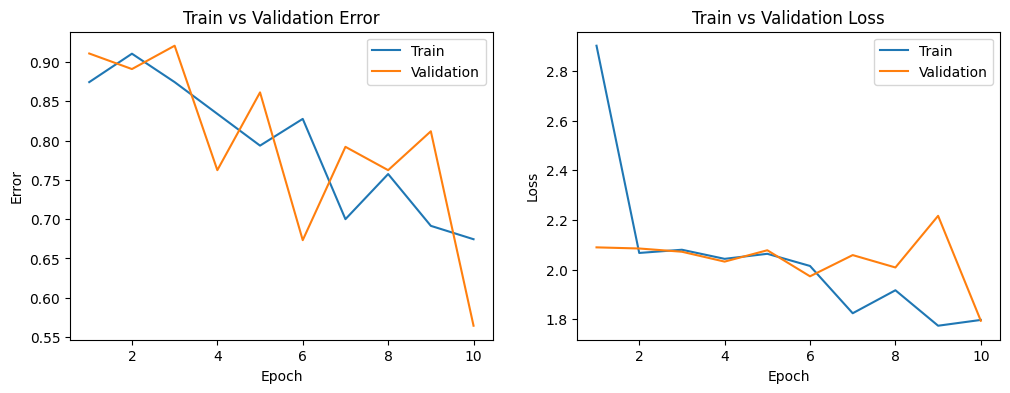

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


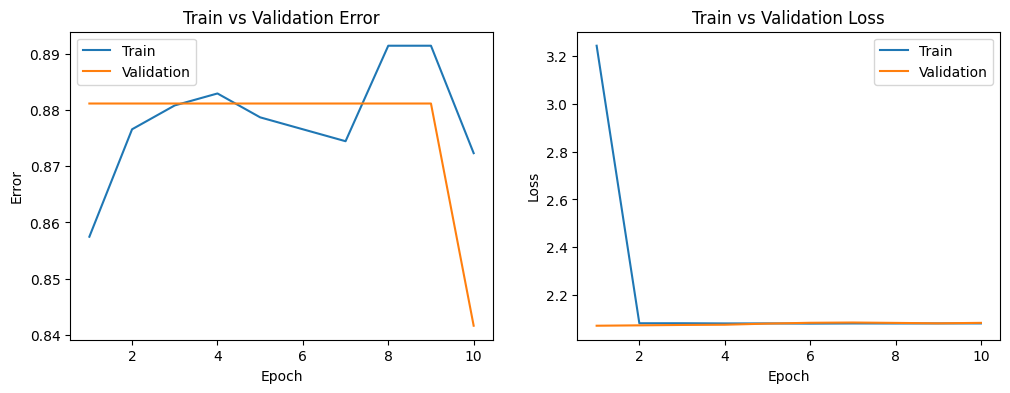

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


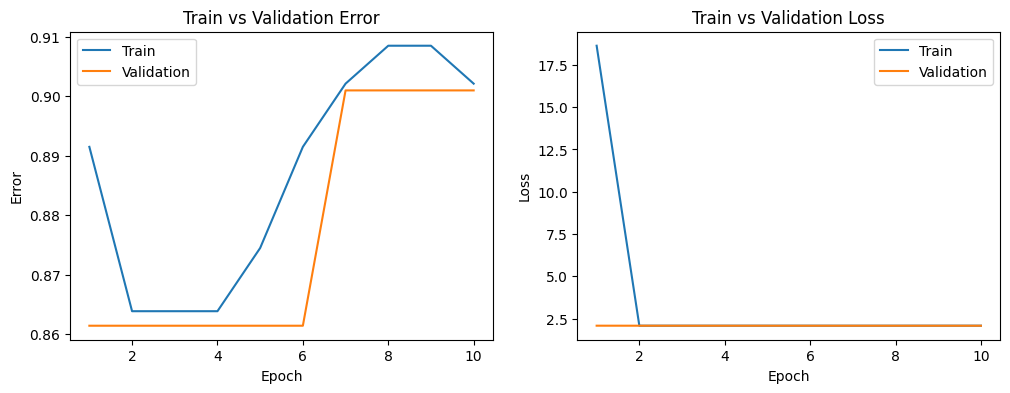

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


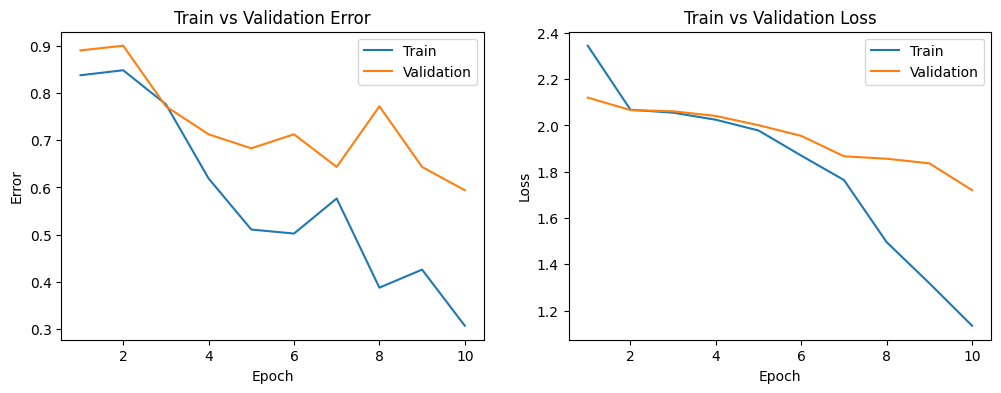

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


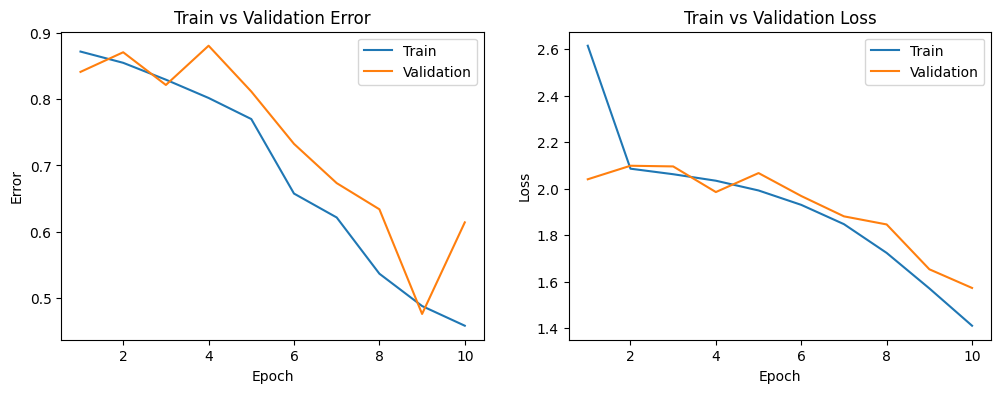

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


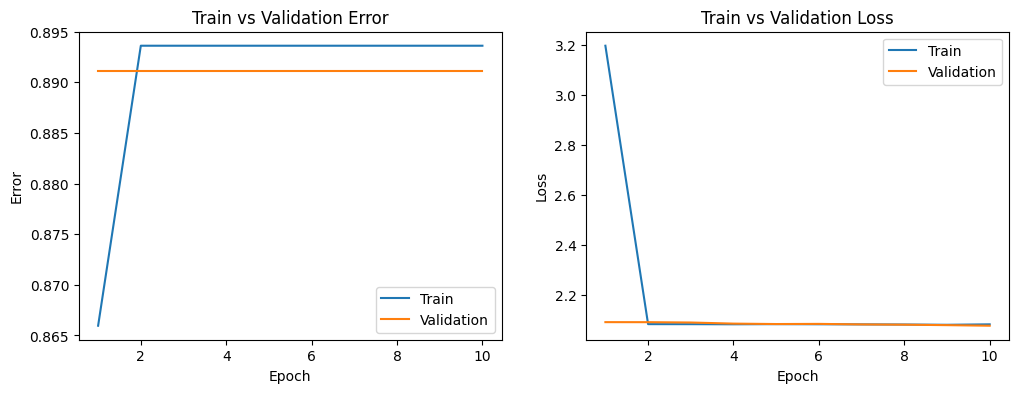

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


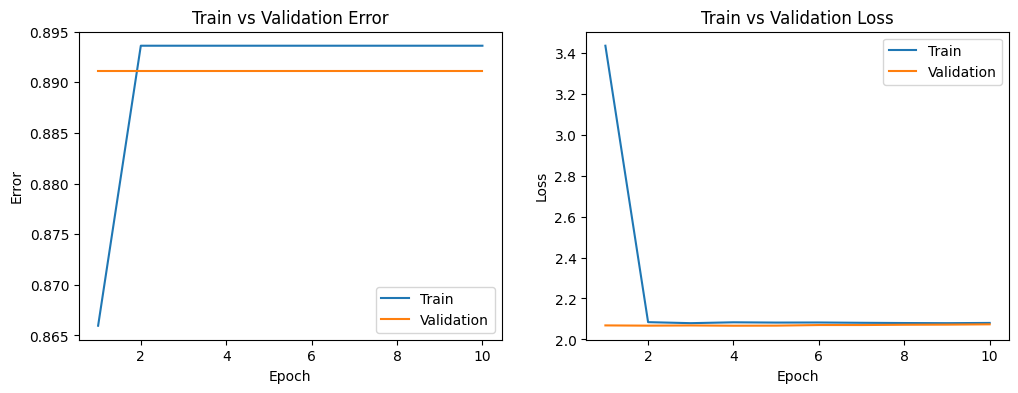

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


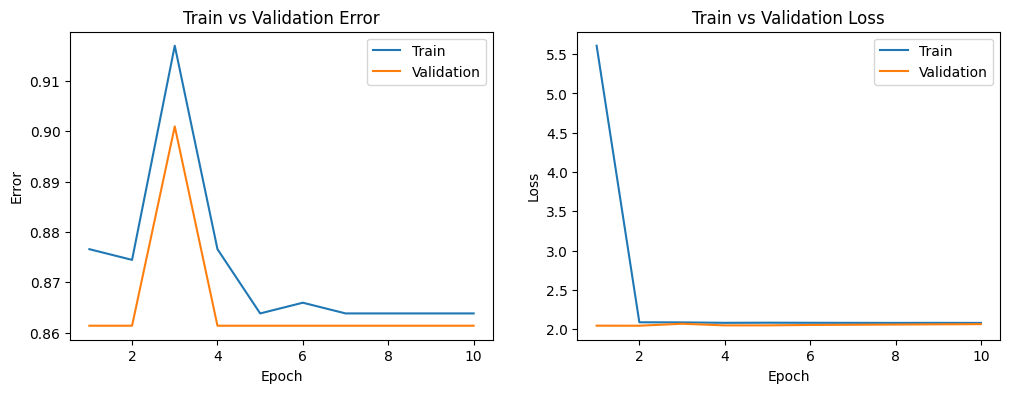

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


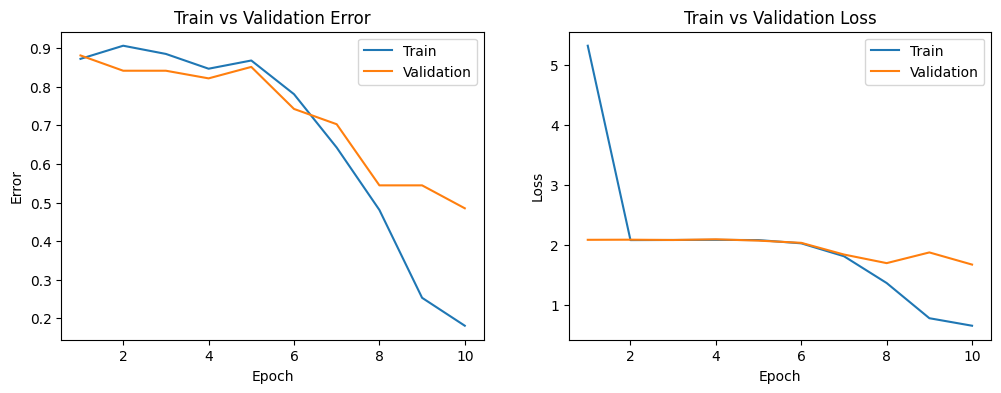

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


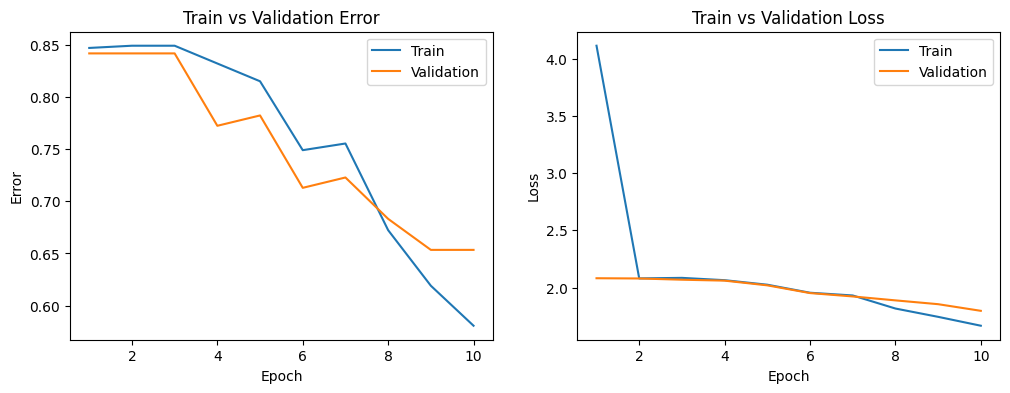

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


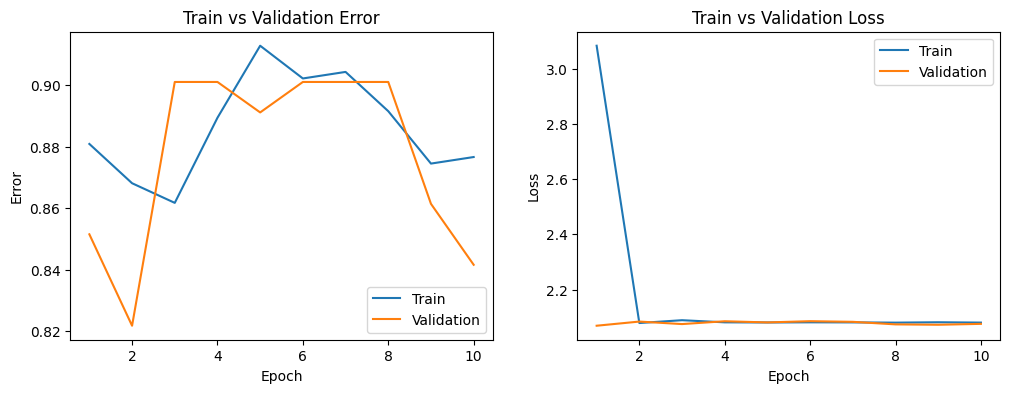

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


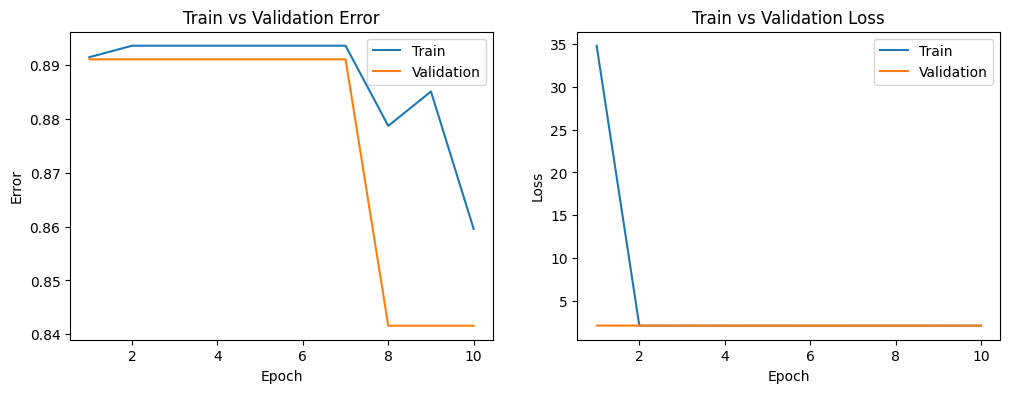

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


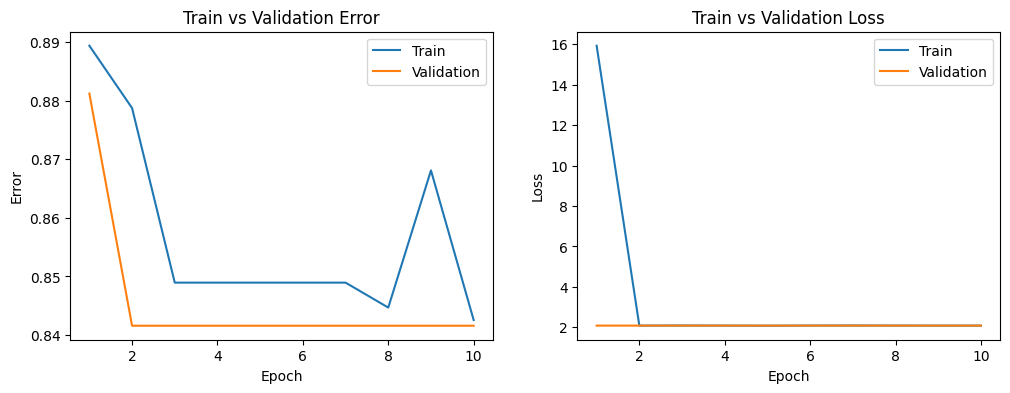

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


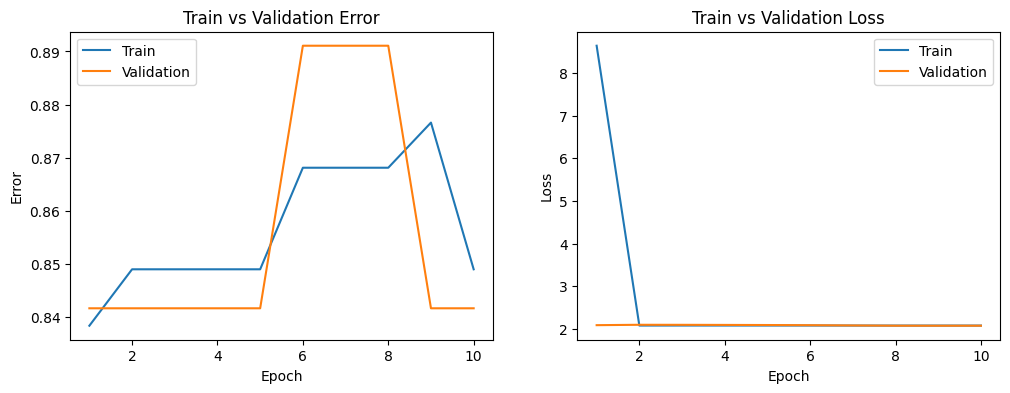

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


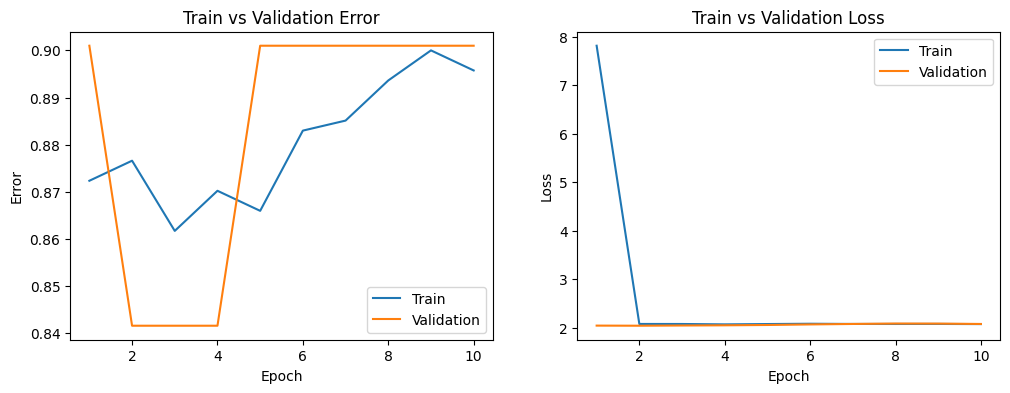

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


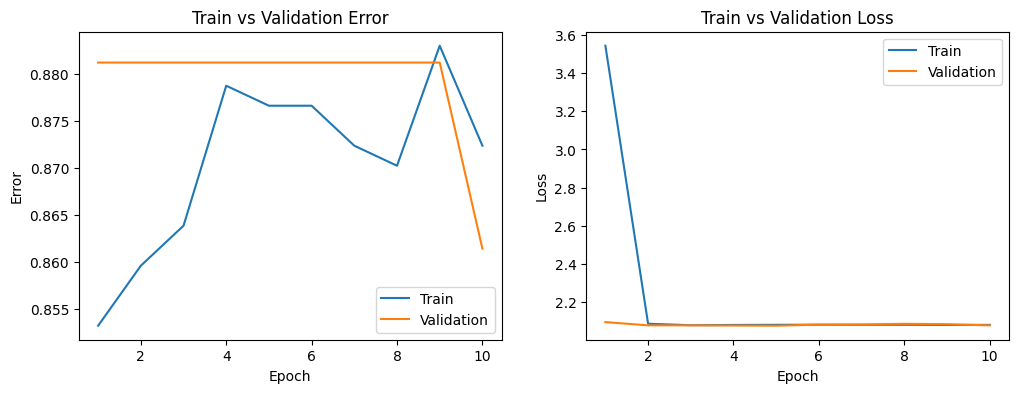

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


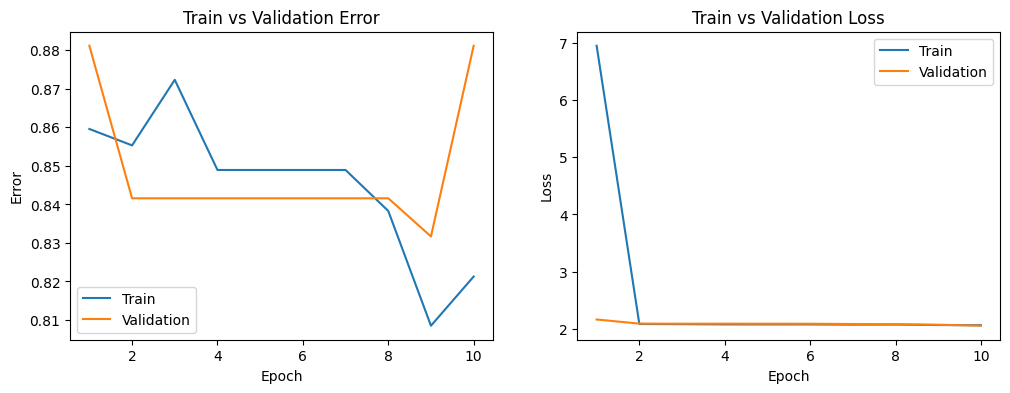

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


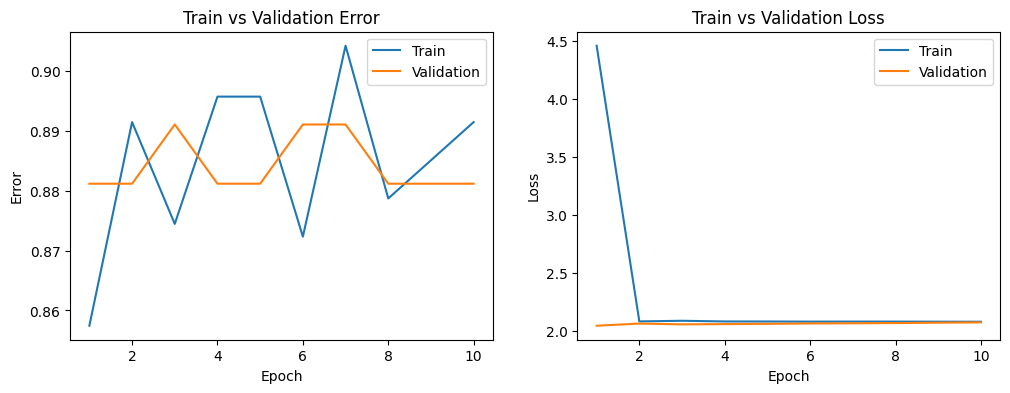

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


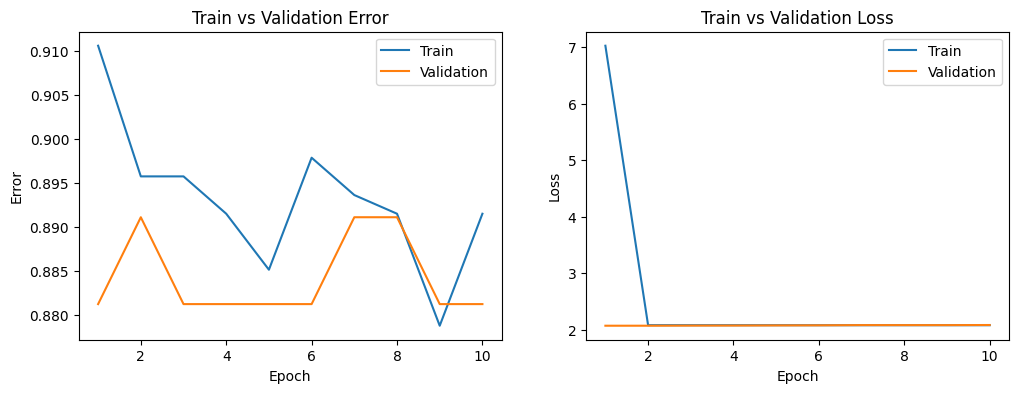

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


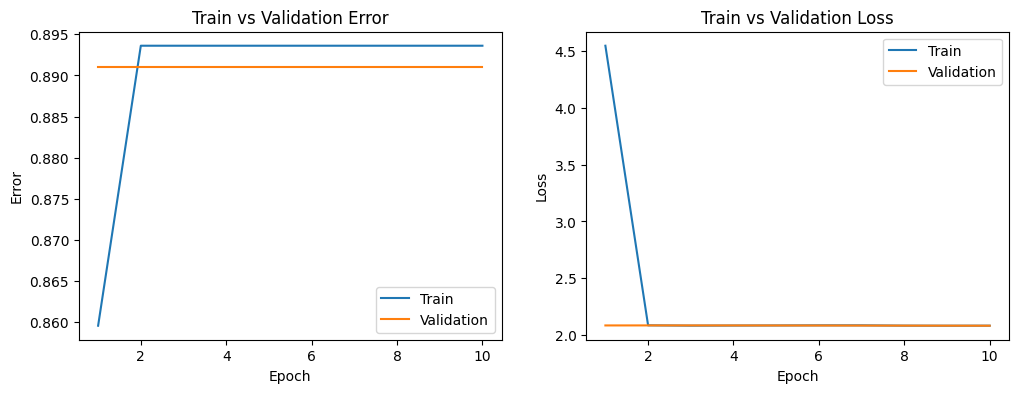

[MEEFO iter 1] Best val error: 0.7257
Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


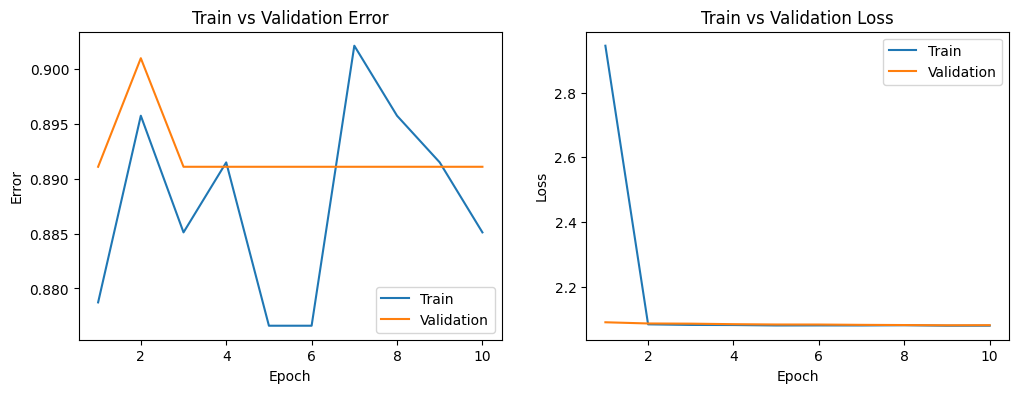

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


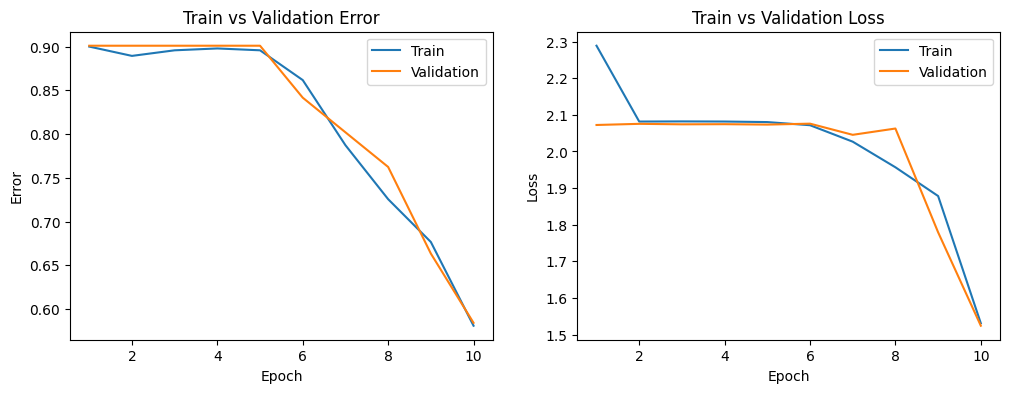

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


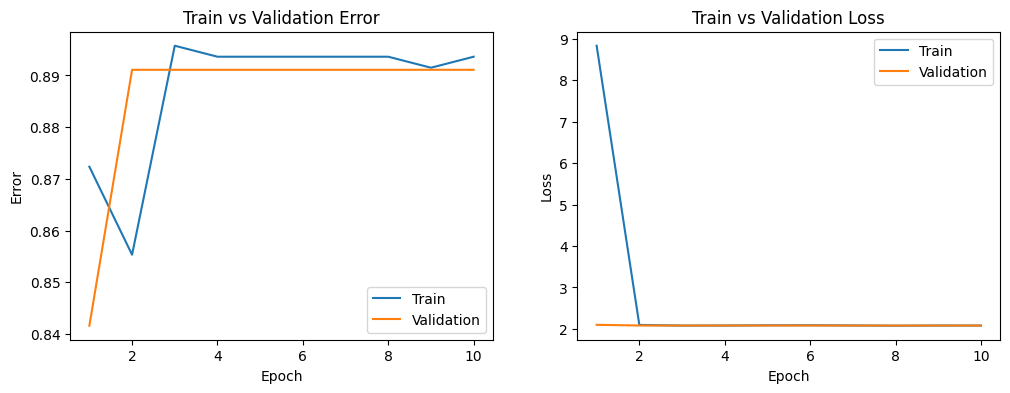

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


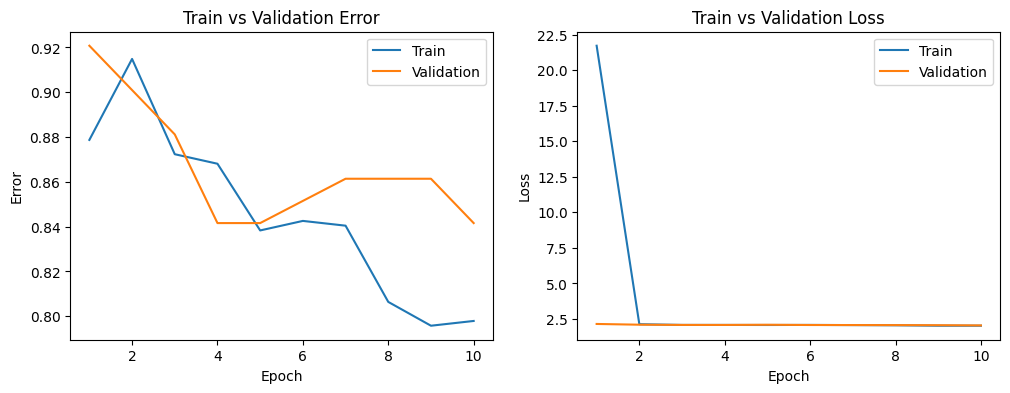

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


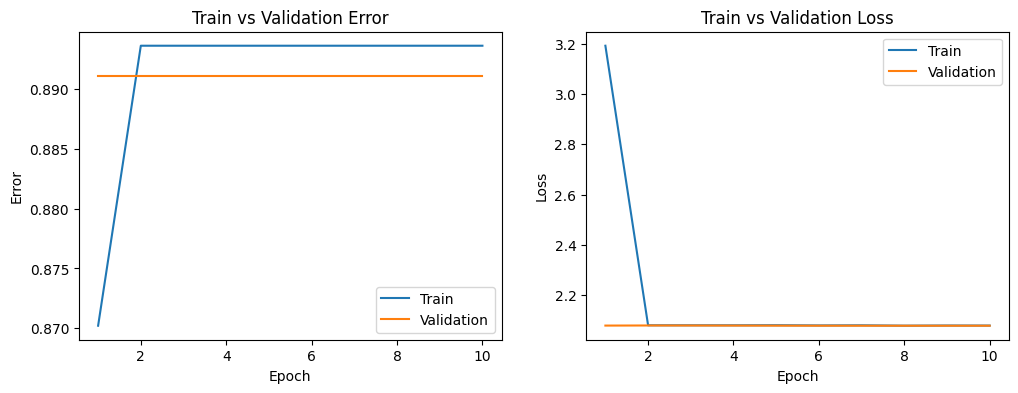

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


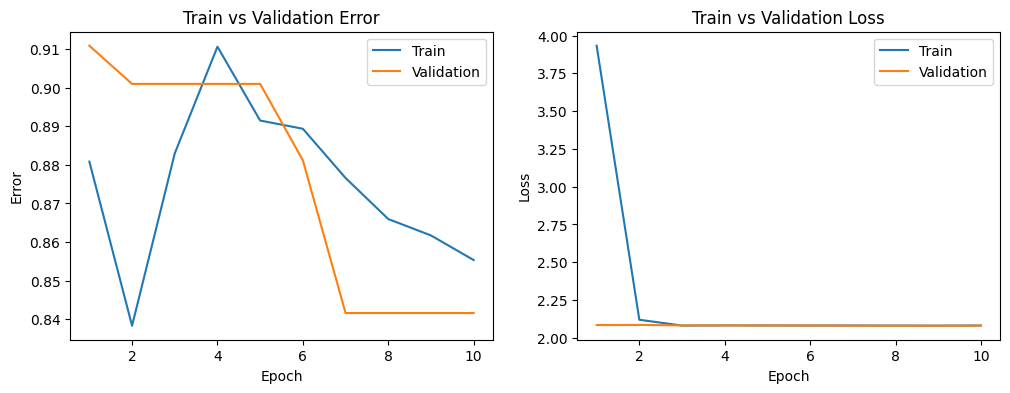

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


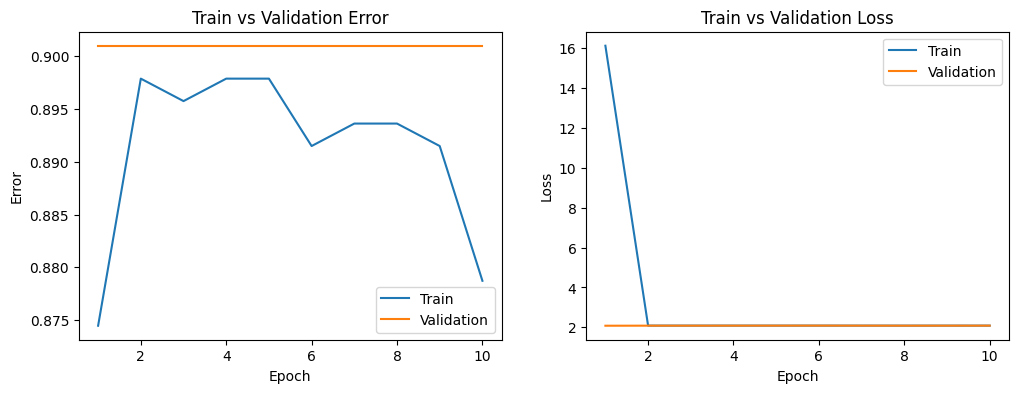

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


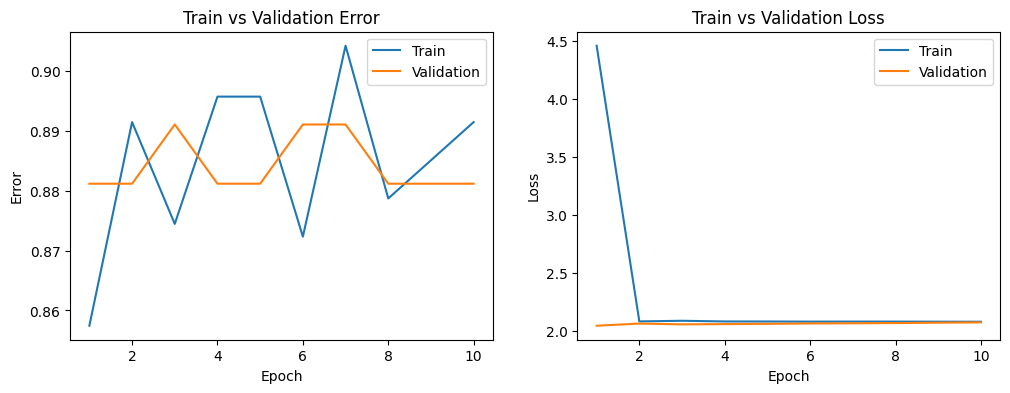

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


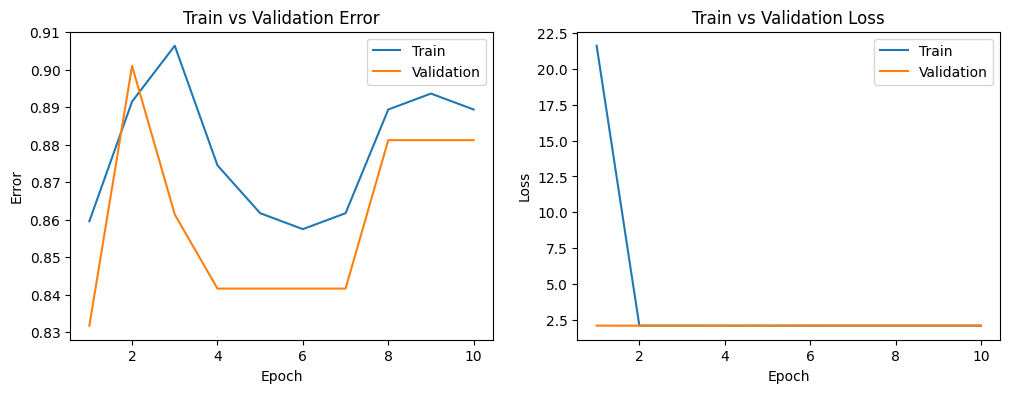

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


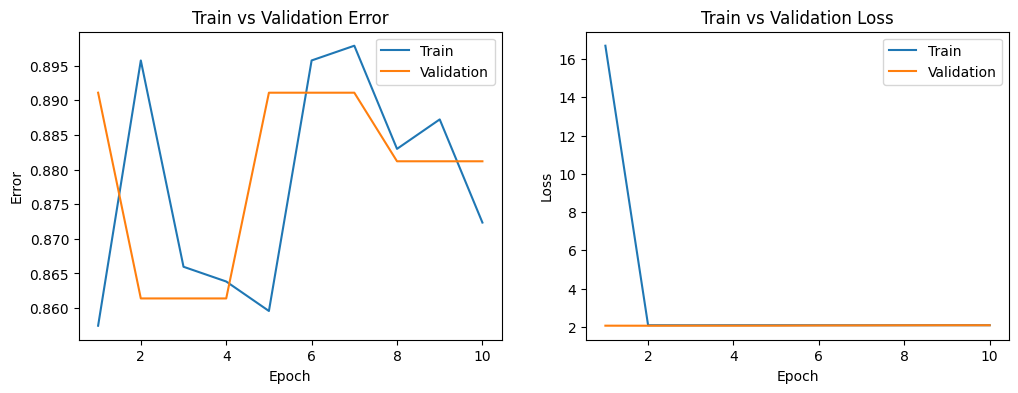

[MEEFO iter 2] Best val error: 0.7257
Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


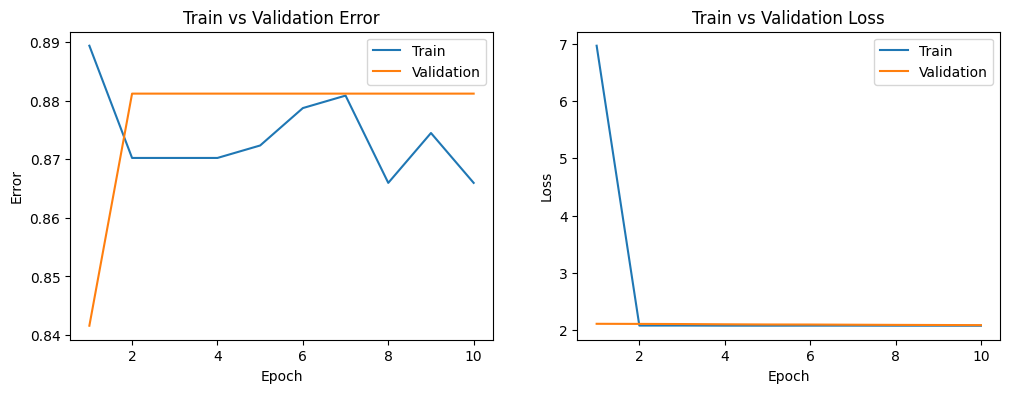

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


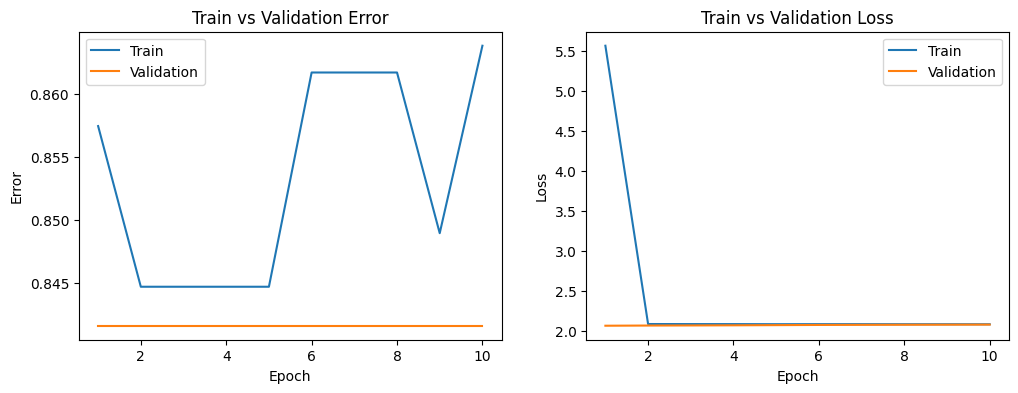

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


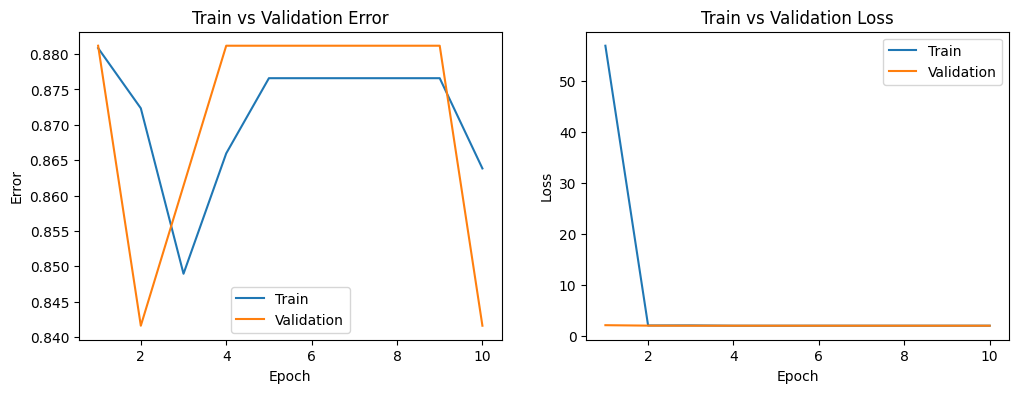

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


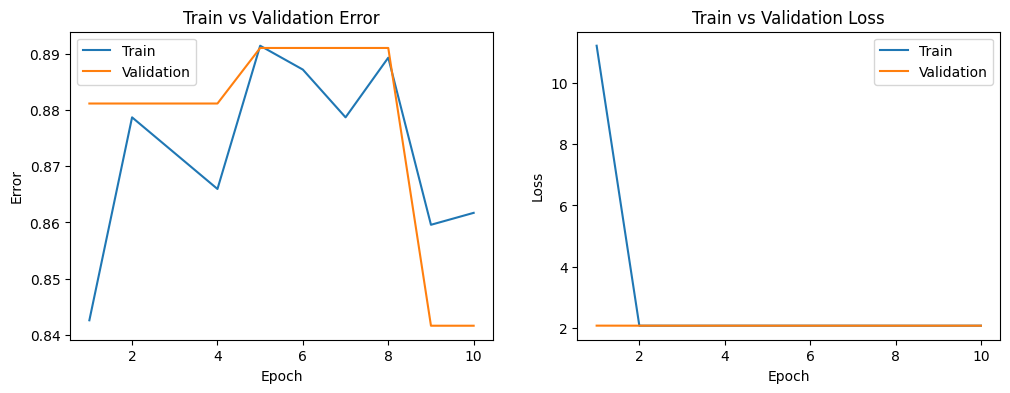

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


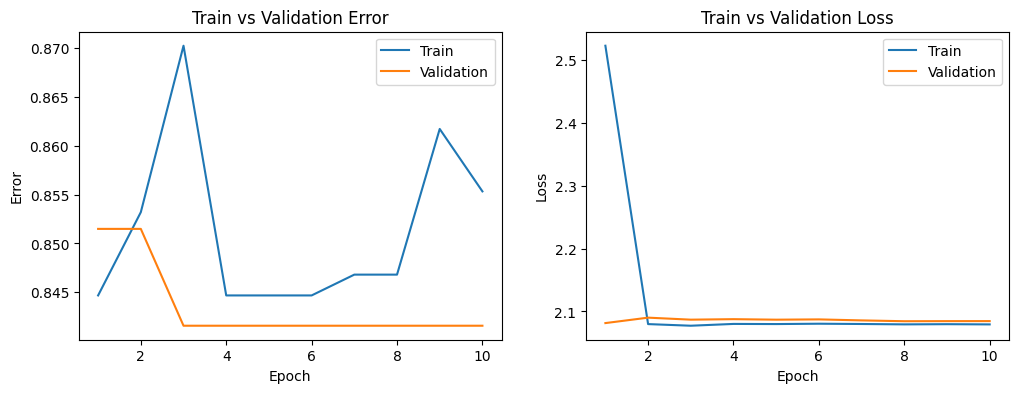

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


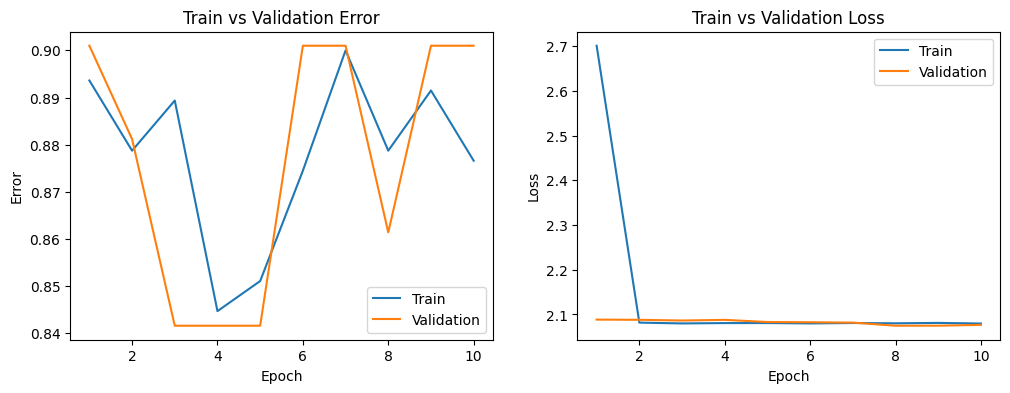

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


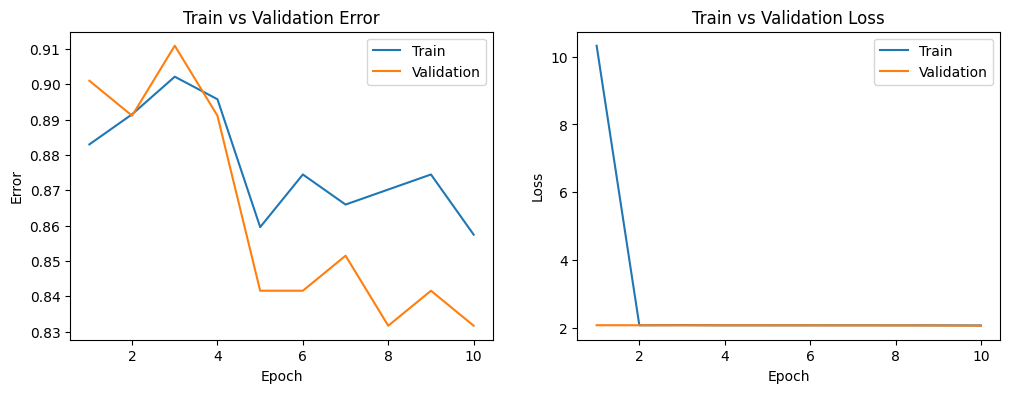

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


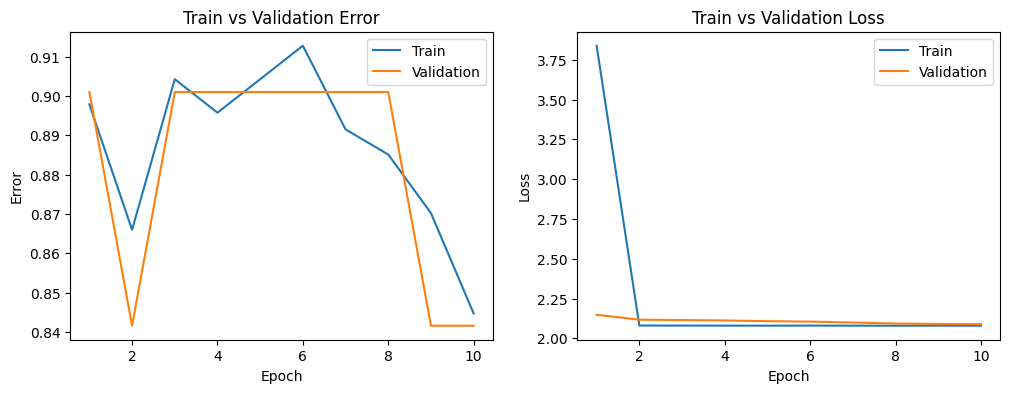

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


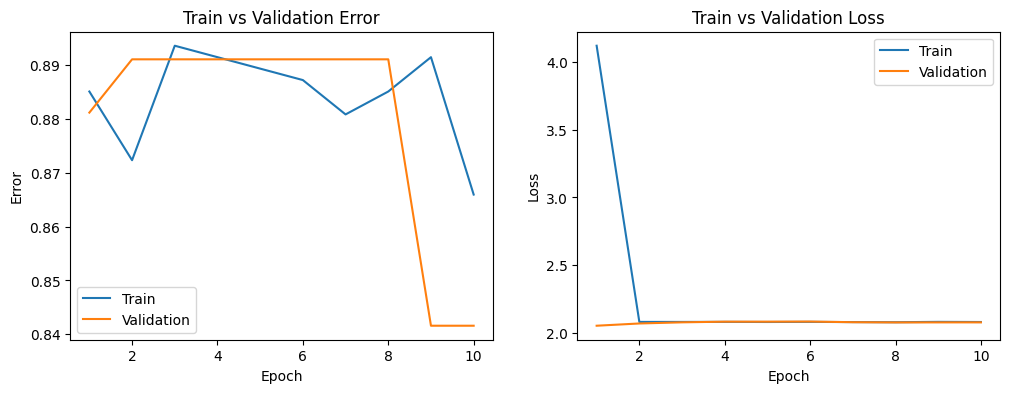

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


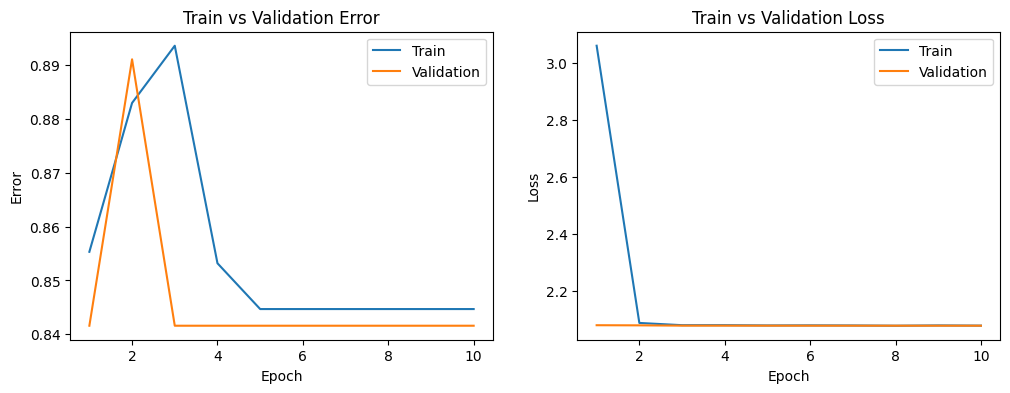

[MEEFO iter 3] Best val error: 0.7257
Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


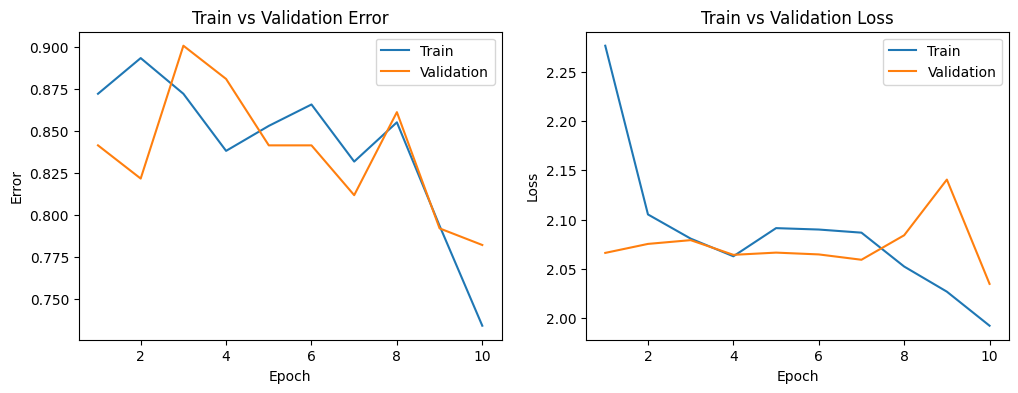

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


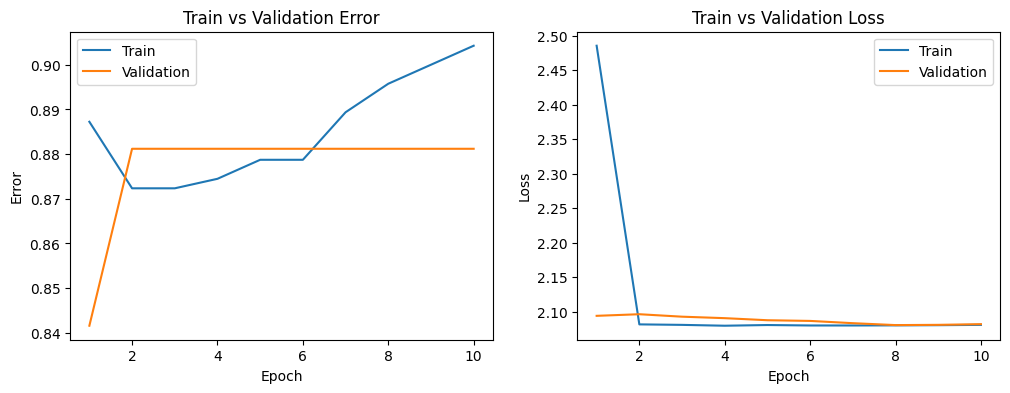

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


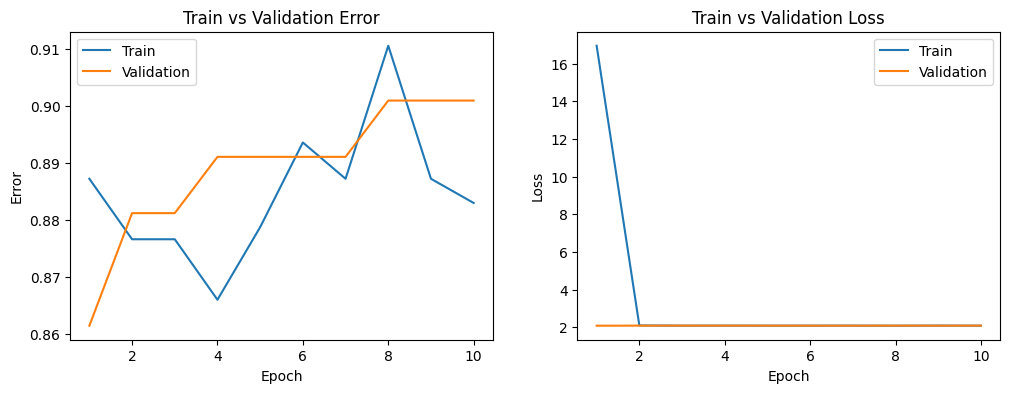

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


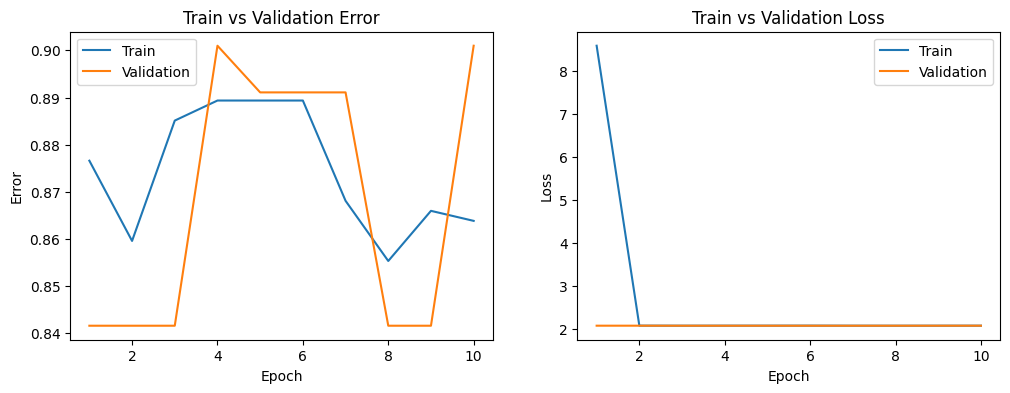

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


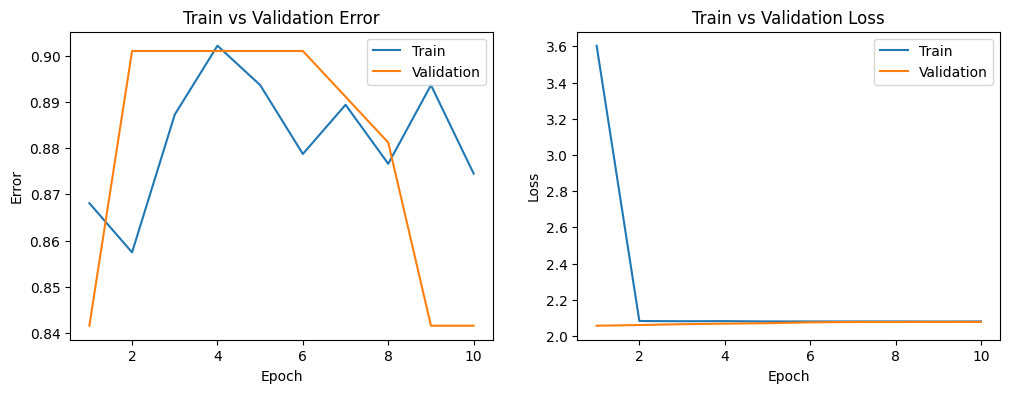

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


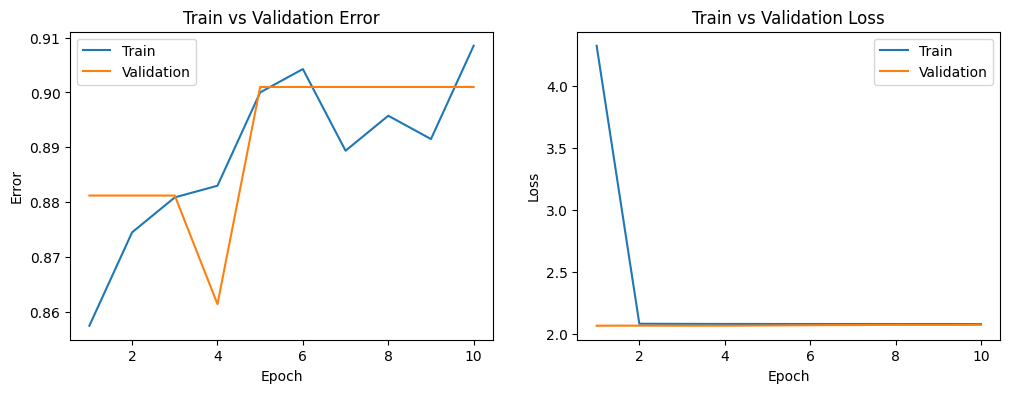

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


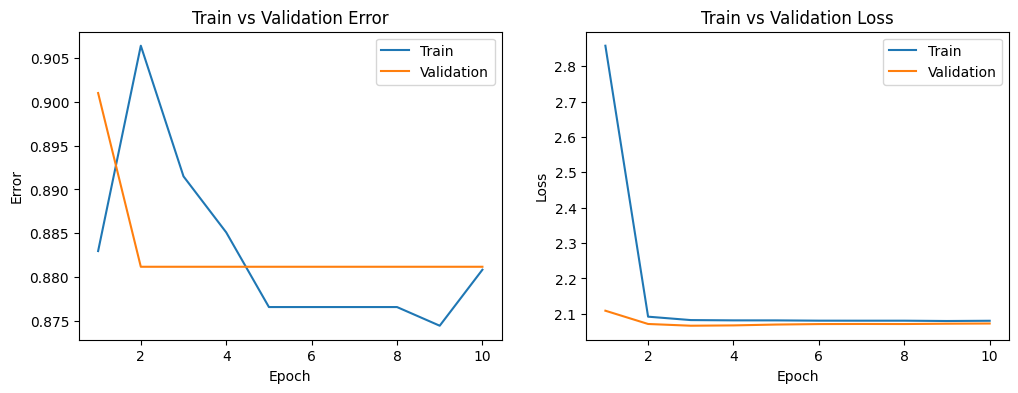

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


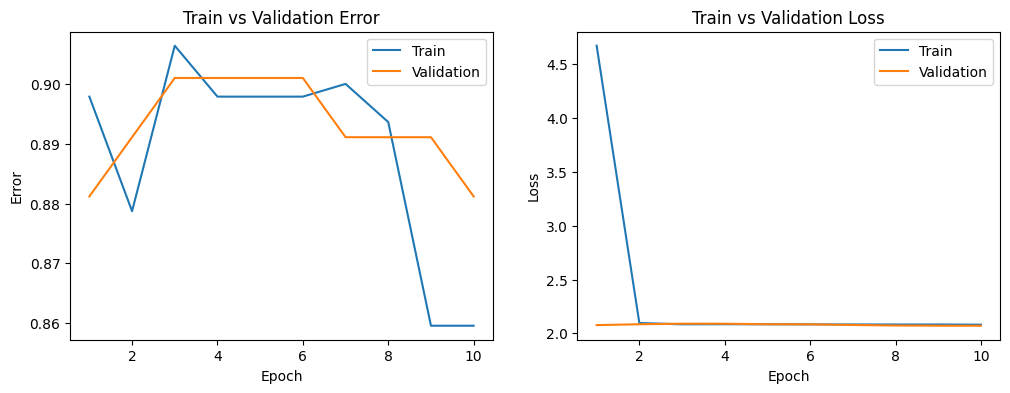

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


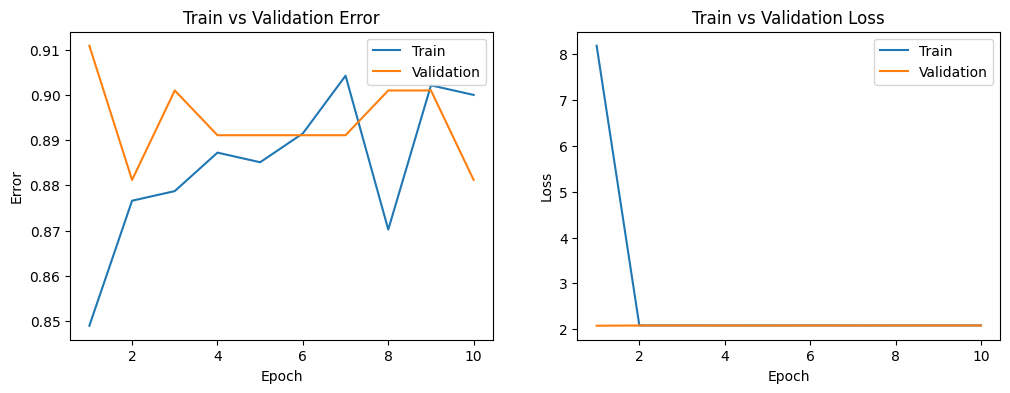

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


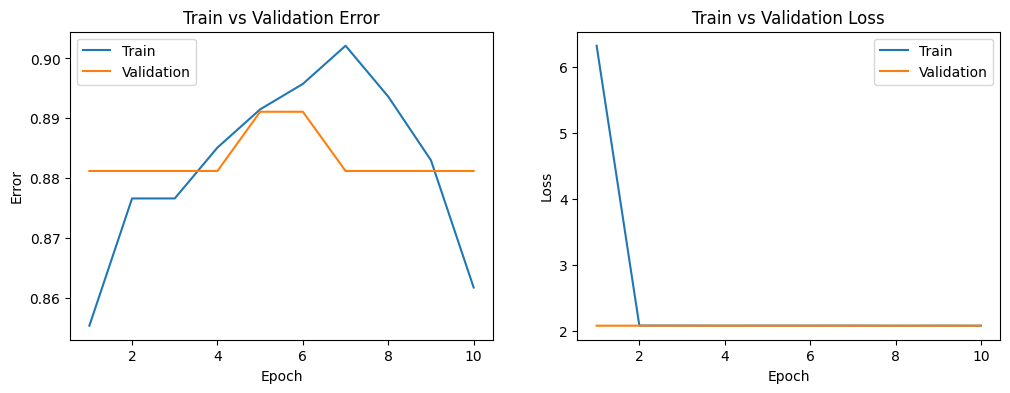

[MEEFO iter 4] Best val error: 0.7257
Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


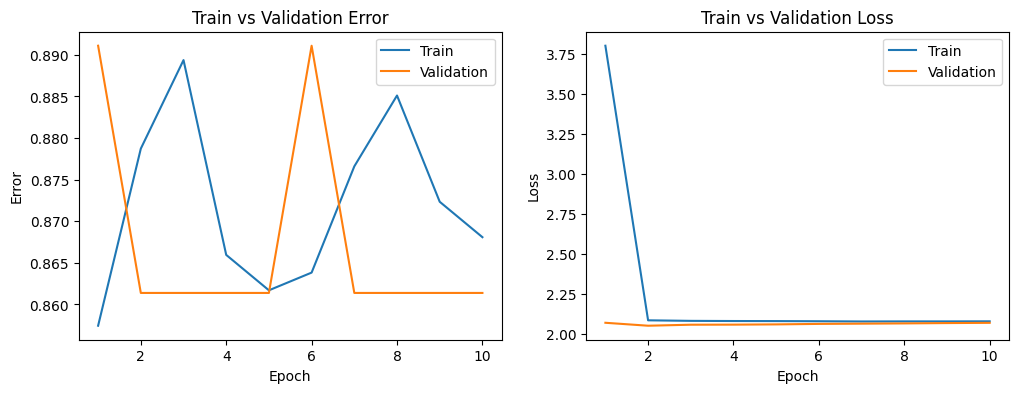

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


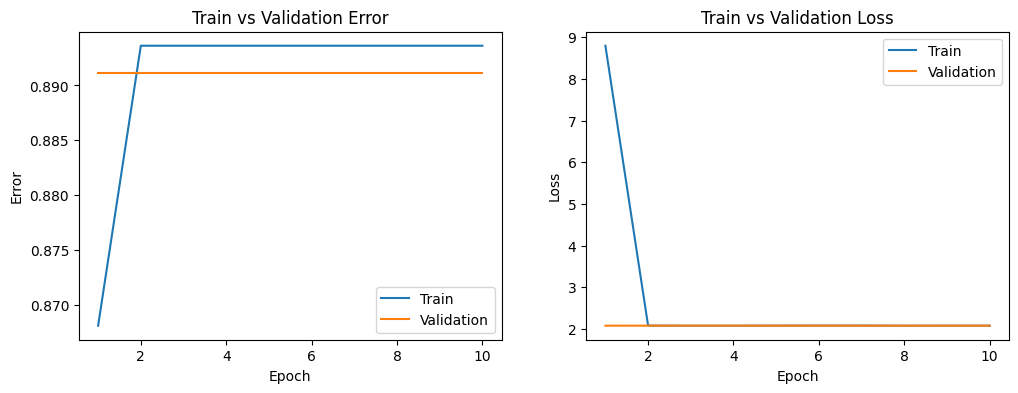

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


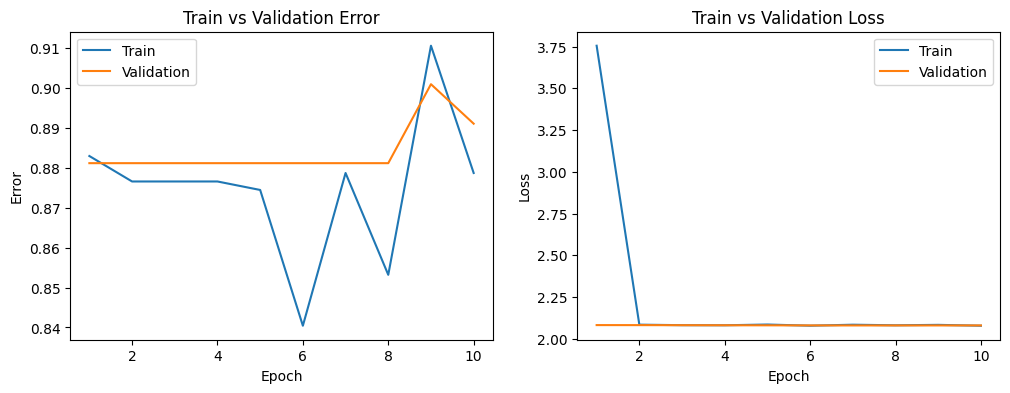

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


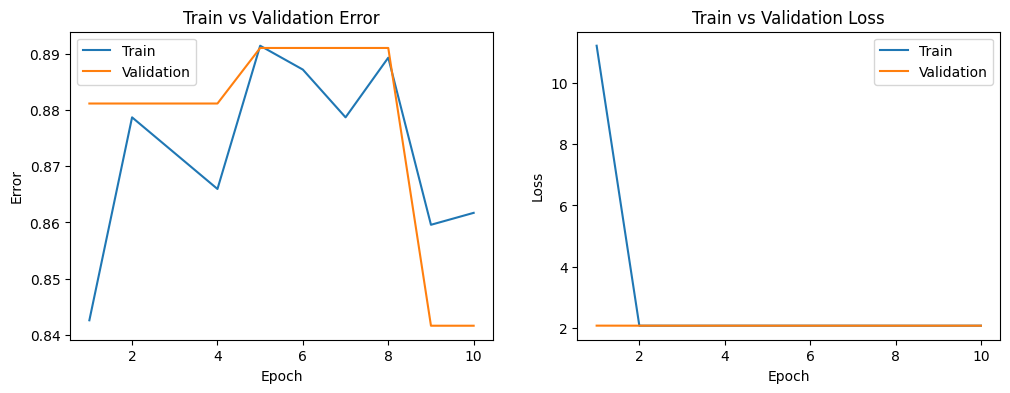

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


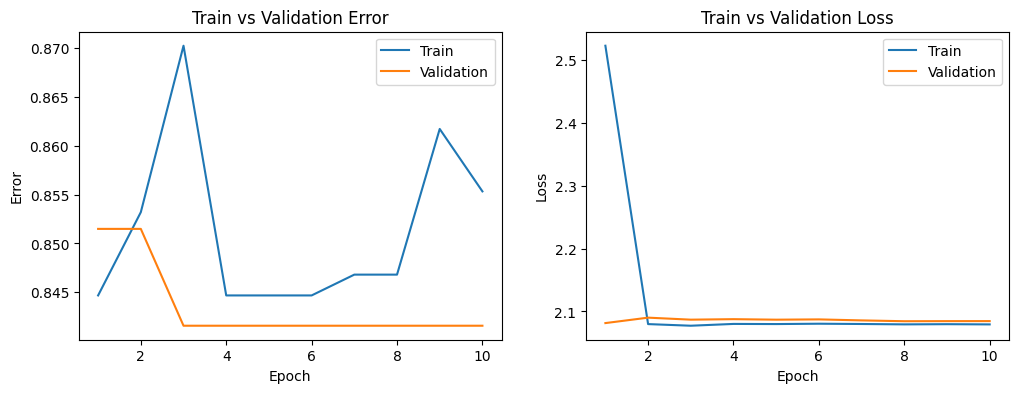

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


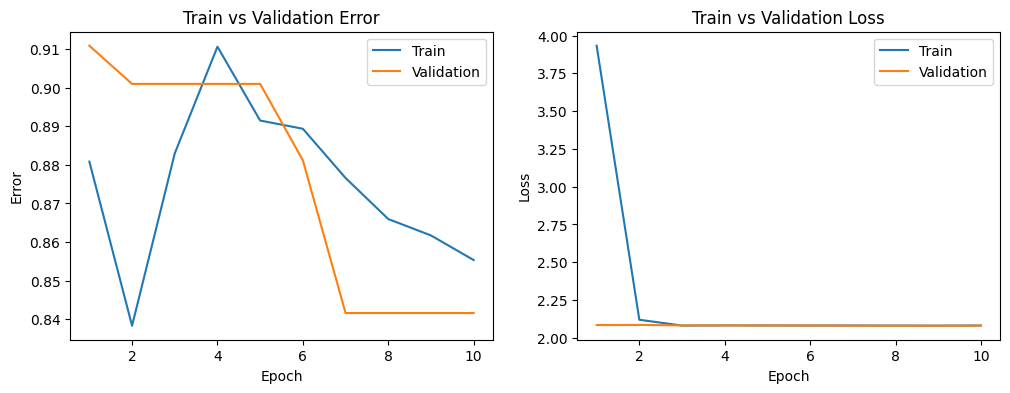

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


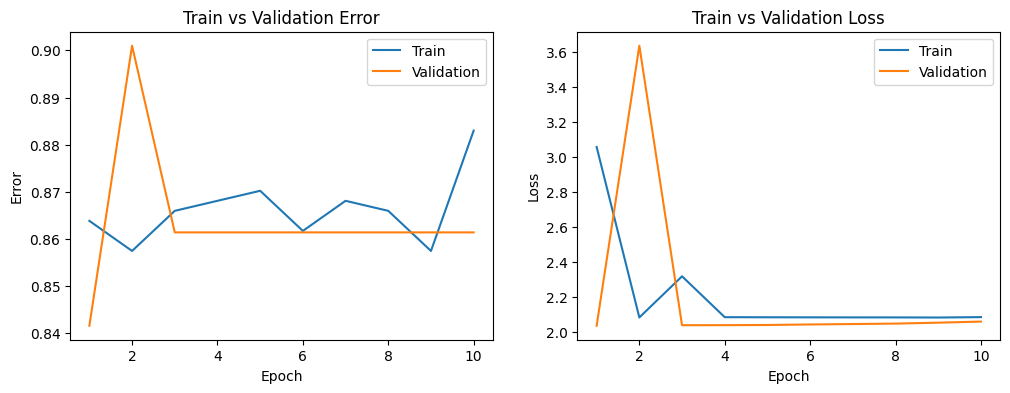

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


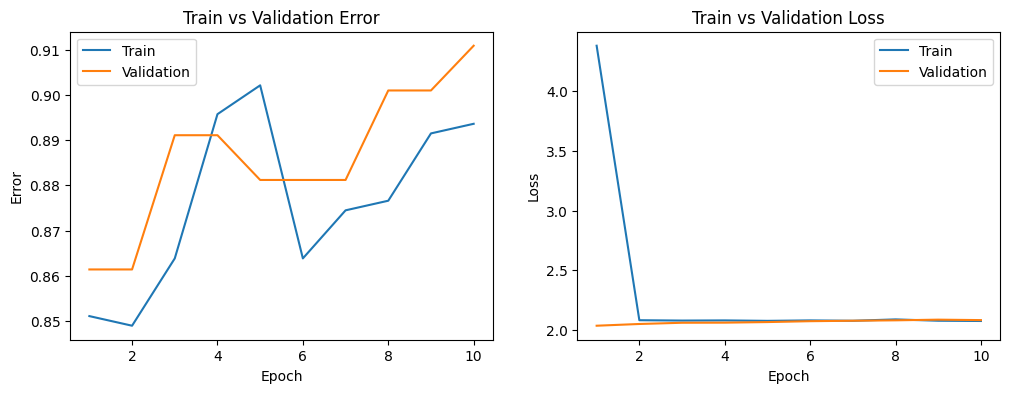

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


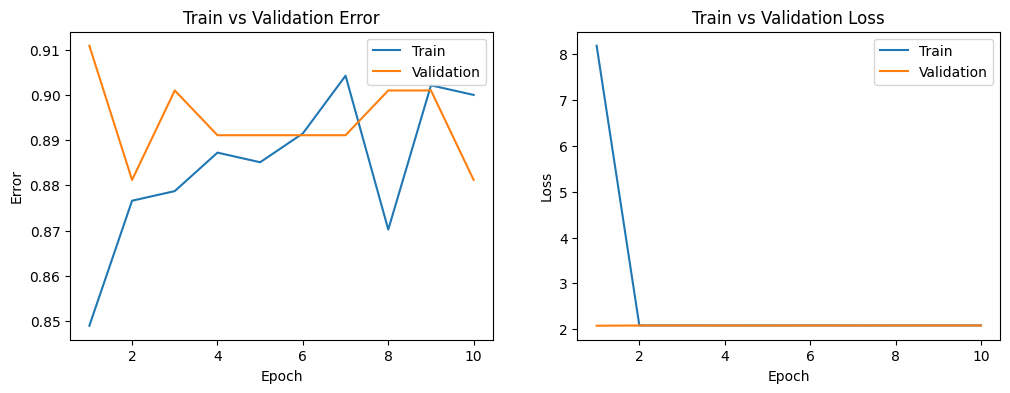

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


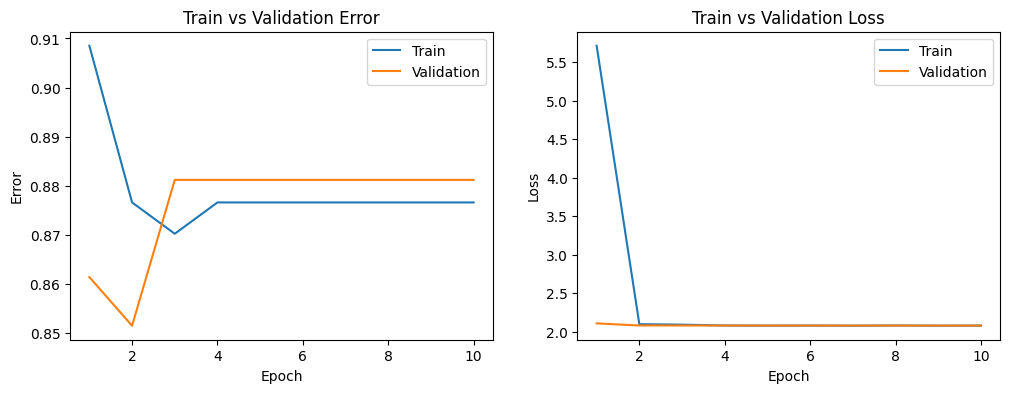

[MEEFO iter 5] Best val error: 0.7257
Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


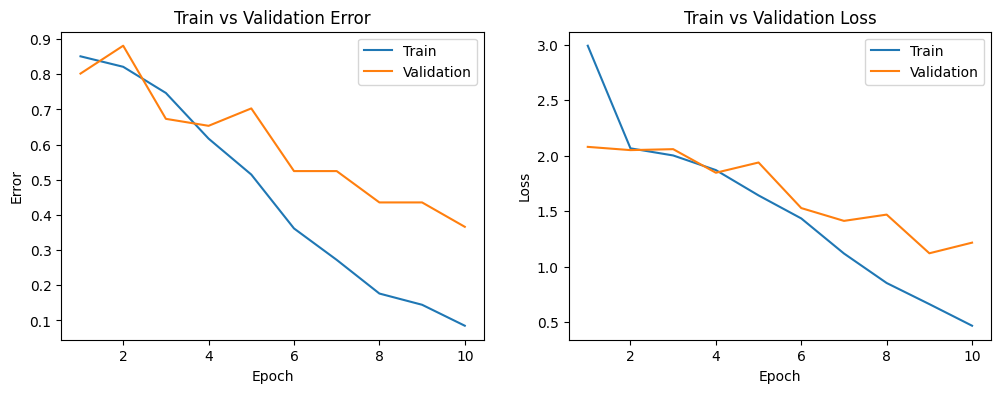

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


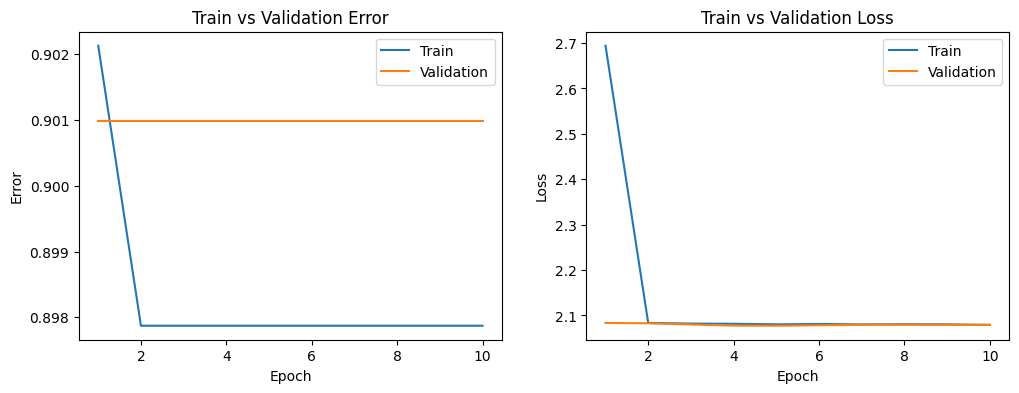

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


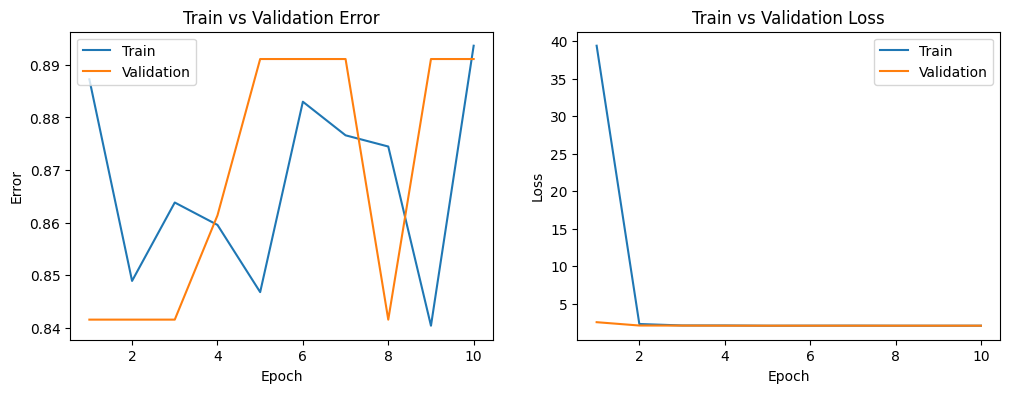

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


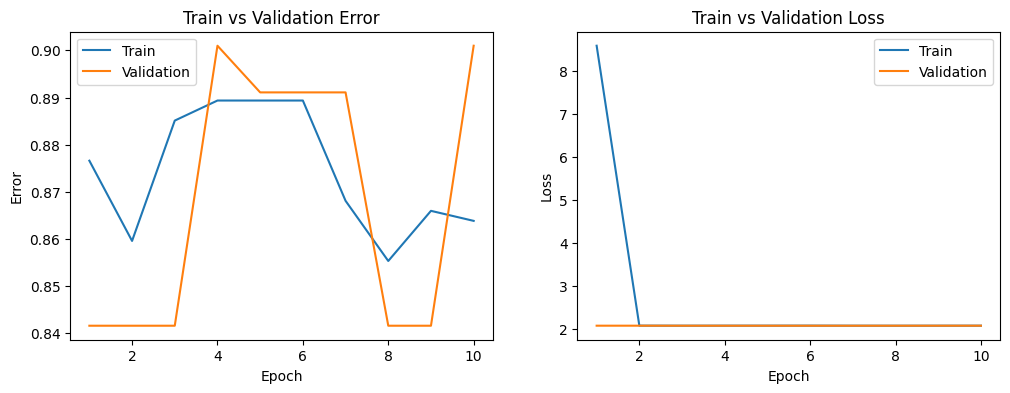

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


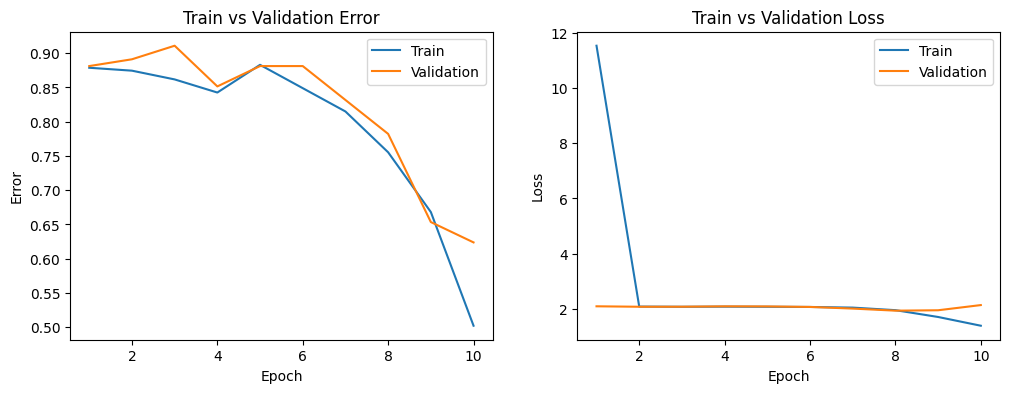

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


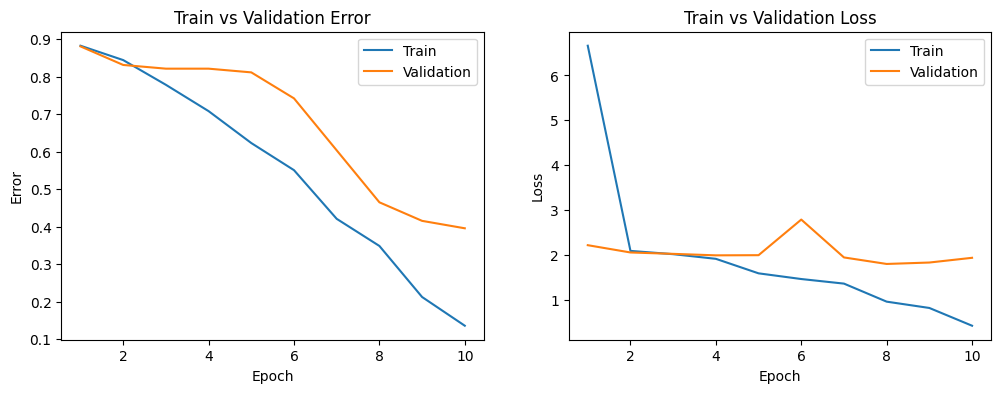

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


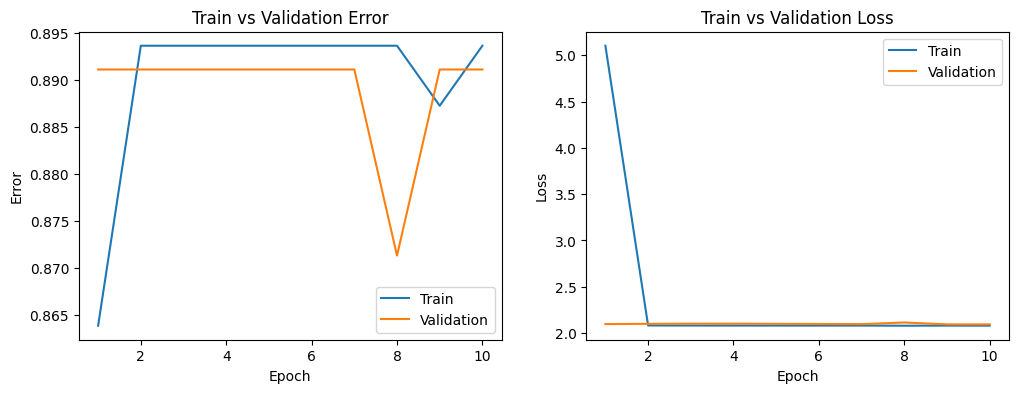

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


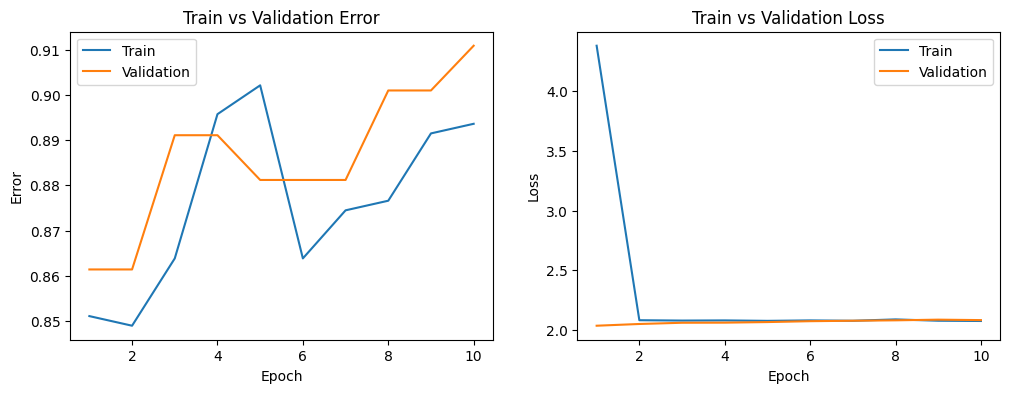

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


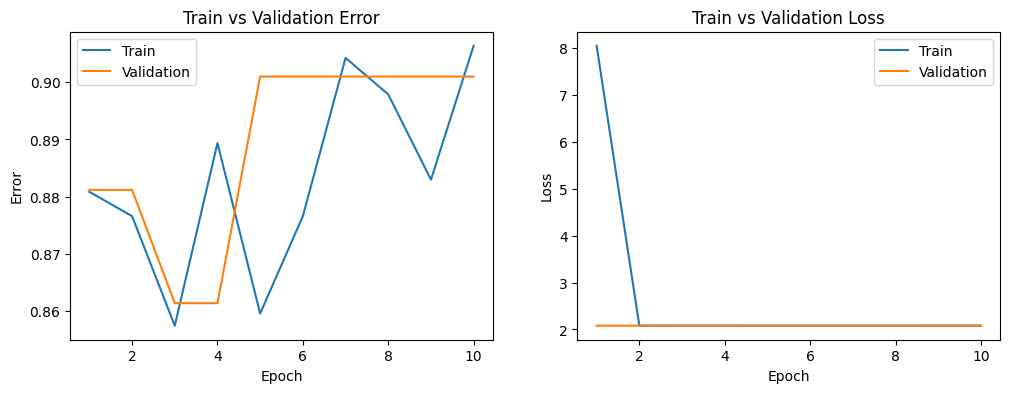

Loaded 470 training, 101 validation, 101 test samples
Classes: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


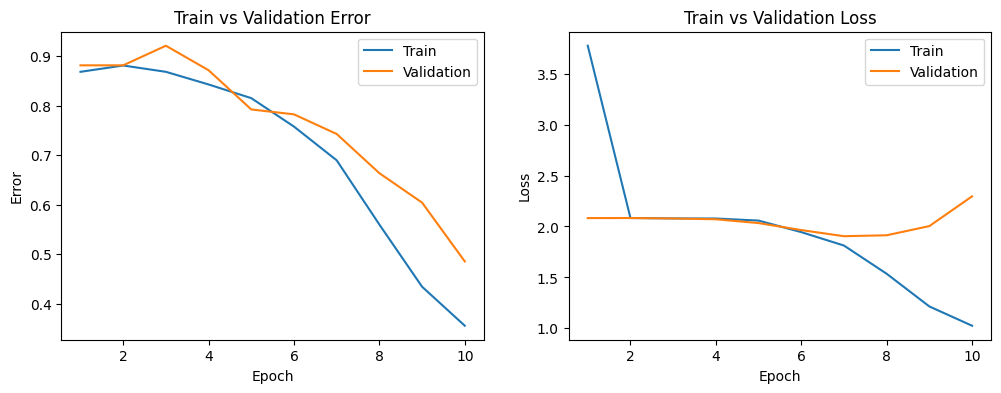

[MEEFO iter 6] Best val error: 0.6000


In [ ]:
target_classes = le.classes_.tolist()

# Run MEEFO
best_params = run_meefo_optimization(fitness_function, search_space, pop_size=10, max_iter=15)

print("\nBest Hyperparameters from MEEFO:")
print(best_params)

# Final training run with best parameters
net = GlizzyNet(num_classes=8, dropout=best_params['dropout'], hidden_size=int(best_params['hidden_size']))
train_net(
    net,
    batch_size=int(best_params['batch_size']),
    learning_rate=best_params['lr'],
    num_epochs=25,
    target_classes=target_classes
)

final_model_path = get_model_name(net.name, int(best_params['batch_size']), best_params['lr'], 24)
plot_training_curve(final_model_path)



In [2]:
# final test on testing data after training model
criterion = nn.CrossEntropyLoss()
_, _, test_loader, _ = get_data_loader(target_classes, best_params['batch_size'])
evaluate_per_class(net, test_loader, le, criterion)

NameError: name 'nn' is not defined